#### Data generation

In [1]:
import timesynth as ts
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [2]:
time_sampler = ts.TimeSampler(stop_time=20)

In [3]:
irregular_time_samples = time_sampler.sample_irregular_time(num_points=500, keep_percentage=50)

In [4]:
irregular_time_samples_diff = np.diff(np.append(0, irregular_time_samples))

In [5]:
phi = 0.10
sigma = 0.2

In [6]:
signal = np.zeros(len(irregular_time_samples)+1)
noise_samples = np.random.normal(size=len(irregular_time_samples))
for i in range(len(irregular_time_samples)):
    signal[i+1] = np.power(phi, irregular_time_samples_diff[i])*signal[i] + \
                    sigma*np.sqrt(1 - np.power(phi, 2*irregular_time_samples_diff[i]))*noise_samples[i]

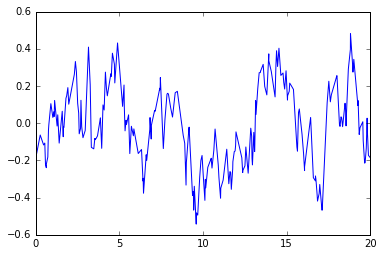

In [7]:
plt.plot(irregular_time_samples, signal[1:])

In [20]:
#Function for building the dictionary
def create_data_dictionary(phi, sigma, irregular_time_samples, signal):
    data_dict = {}
    data_dict['phi'] = phi
    data_dict['sigma'] = sigma
    data_dict['time_samples'] = list(irregular_time_samples)
    data_dict['signal'] = list(signal)
    return data_dict

In [21]:
def write_file(file_name, data_dict):
    with open('../corr_data/'+file_name+'.json', 'w') as fp:
        json.dump(data_dict, fp)

In [22]:
def read_file(file_name):
    with open('../corr_data/'+file_name+'.json', 'r') as fp:
        data = json.load(fp)
    return data

In [23]:
def generate_data(phi, sigma, num_points):
    time_sampler = ts.TimeSampler(stop_time=20)
    irregular_time_samples = time_sampler.sample_irregular_time(num_points=num_points,
                                                                keep_percentage=50)
    irregular_time_samples_diff = np.diff(np.append(0, irregular_time_samples))
    signal = np.zeros(len(irregular_time_samples)+1)
    noise_samples = np.random.normal(size=len(irregular_time_samples))
    for i in range(len(irregular_time_samples)):
        signal[i+1] = np.power(phi, irregular_time_samples_diff[i])*signal[i] + \
                        sigma*np.sqrt(1 - np.power(phi, 2*irregular_time_samples_diff[i]))*noise_samples[i]
    return irregular_time_samples, signal[1:]

#### Automating the process for dataset generation

In [34]:
num_samples = 10000
phi_samples = np.random.uniform(size=num_samples)
sigma_samples = np.random.uniform(size=num_samples)
signal_lengths = np.random.randint(low=500, high=1000, size=num_samples)

In [35]:
for i in range(num_samples):
    sigma = sigma_samples[i]
    phi = phi_samples[i]
    sig_length = signal_lengths[i]
    signal = np.nan
    while np.any(np.isnan(signal)):
        time_samples, signal = generate_data(phi, sigma, 600)
    data_dict = create_data_dictionary(phi, sigma, time_samples, signal)
    file_name = 'series_'+str(i)
    write_file(file_name, data_dict)

#### Building the models for learning phi alone

In [2]:
import timeflow as tflow
import tensorflow as tf

In [3]:
class RegressionLayer():
    """
    Layer implements the Simple regression.
    """
    def __init__(self, input_size, output_size, input_layer):
        """Initialize RegressionLayer class

        Parameters
        ----------
        input_size : integer
            Input dimensions
        output_size : integer
            Output dimensions
        input_layer : layers object
            Preceding layers object

        """
        self.inputs = input_layer
        self.input_size = input_size
        self.output_size = output_size
        self.Wo = tf.Variable(tf.truncated_normal([self.input_size, self.output_size], mean=0, stddev=.01))
        self.bo = tf.Variable(tf.truncated_normal([self.output_size], mean=0, stddev=.01))

    def get_output(self, input_):
        """
        Generates the output for a single step

        Parameters
        ----------
        input_ : tf.tensor
            Input tensor

        Returns
        ----------
        tf.tensor
            Output tensor

        """
        output = tf.matmul(input_, self.Wo) + self.bo
        return output

    def get_outputs(self):
        """
        Iterates through all inputs to generate outputs

        Returns
        ----------
        tf.Tensor
            Output tensor

        """
        all_outputs = tf.map_fn(self.get_output, self.inputs)
        return all_outputs

In [4]:
input_size = 2
hidden_size = 10
output_size = 1
batch_size = 50

In [5]:
with tf.variable_scope('Input'):
    inputs = tflow.placeholders.prediction.input_batch_placeholder(input_size, batch_size)
with tf.variable_scope('Input_LSTM_Layer'):
    input_lstm_layer = tflow.layers.InputLSTMLayer(inputs, input_size, batch_input=True)
with tf.variable_scope('LSTM_Layer'):
    lstm_layer = tflow.layers.LSTMLayer(input_size, hidden_size, input_lstm_layer)

In [6]:
pre_output = tf.expand_dims(tf.reduce_mean(lstm_layer.get_outputs(), reduction_indices=1), 1)

In [7]:
with tf.variable_scope('Reg_Layer'):
    reg_layer = RegressionLayer(hidden_size, output_size, pre_output)

In [8]:
with tf.variable_scope('Reg_Layer'):
    output_layer = tflow.layers.OutputLSTMLayer(output_size, reg_layer, batch_output=True)

In [9]:
y = tf.placeholder(tf.float32, shape=[batch_size, output_size],name='outputs')

In [11]:
outputs = tf.reduce_mean(output_layer.get_outputs(), reduction_indices=2)

In [13]:
rmse = tflow.utils.metrics.RMSE(outputs, y)

In [14]:
tf.scalar_summary("RMSE", rmse)
summary_op = tf.merge_all_summaries()

In [15]:
#Training with Adadelta Optimizer
train_step = tf.train.AdamOptimizer().minimize(rmse)

In [16]:
# Starting tensorflow session
sess=tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [17]:
#Setting up log directory for tensorboard
logs_path = 'tmp/corr/1'
writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

In [18]:
def build_batch_input(val, batch_size):
    outputs = np.zeros(batch_size)
    counter = 0
    for k in range(val*batch_size, (val+1)*batch_size):
        data_dict = read_file('series_'+str(k))
        time_samples = data_dict['time_samples']
        samples = data_dict['signal']
        outputs[counter] = data_dict['phi']
        if counter == 0:
            input_vector = np.transpose(np.concatenate(
                                    (np.array(time_samples, ndmin=2),
                                     np.array(samples, ndmin=2)), axis=0))
        elif counter == 1:
            value_vector = np.transpose(np.concatenate(
                                    (np.array(time_samples, ndmin=2),
                                     np.array(samples, ndmin=2)), axis=0))
            input_vector = np.stack((input_vector, value_vector))
        else:
            value_vector = np.transpose(np.concatenate(
                                    (np.array(time_samples, ndmin=2),
                                     np.array(samples, ndmin=2)), axis=0))
            input_vector = np.append(input_vector, np.expand_dims(value_vector, 0), axis=0)
        counter += 1
    return input_vector, np.reshape(outputs, (batch_size, 1))

In [24]:
input_vector, out_vector = build_batch_input(0, 10)

In [99]:
index = 200/50

In [100]:
for i in range(2, index):
    input_vector, out_vector = build_batch_input(i, batch_size)
    for k in range(5000):
        _, summary = sess.run([train_step, summary_op],
                             feed_dict={inputs:input_vector,
                                        y:out_vector})
        
    score = sess.run(rmse, feed_dict={inputs:input_vector,
                                    y:out_vector})
    print "Batch "+str(i+1)+" Completed with RMSE: "+str(score)

Batch 3 Completed with RMSE: 0.000186424
Batch 4 Completed with RMSE: 0.00249247


In [29]:
data_dict = read_file('series_'+str(0))
time_samples = data_dict['time_samples']
samples = data_dict['signal']

In [30]:
def build_test_batch_input(file_num, batch_size):
    data_dict = read_file('series_'+str(file_num))
    time_samples = data_dict['time_samples']
    samples = data_dict['signal']
    outputs = data_dict['phi']
    for k in range(batch_size):
        if k == 0:
            input_vector = np.transpose(np.concatenate(
                                    (np.array(time_samples, ndmin=2),
                                     np.array(samples, ndmin=2)), axis=0))
        elif k == 1:
            value_vector = np.transpose(np.concatenate(
                                    (np.array(time_samples, ndmin=2),
                                     np.array(samples, ndmin=2)), axis=0))
            input_vector = np.stack((input_vector, value_vector))
        else:
            value_vector = np.transpose(np.concatenate(
                                    (np.array(time_samples, ndmin=2),
                                     np.array(samples, ndmin=2)), axis=0))
            input_vector = np.append(input_vector, np.expand_dims(value_vector, 0), axis=0)
    return input_vector, outputs

In [95]:
in_test, value = build_batch_input(1, batch_size)

In [96]:
out = sess.run(outputs, feed_dict={inputs:in_test})

In [97]:
value-out

array([[ 0.00022764],
       [-0.00160477],
       [-0.0060283 ],
       [ 0.00517172],
       [ 0.00411643],
       [ 0.0177103 ],
       [-0.02389319],
       [-0.00069429],
       [ 0.00495244],
       [ 0.02235382],
       [-0.01253975],
       [-0.01076528],
       [-0.01327215],
       [ 0.00846936],
       [ 0.00093652],
       [ 0.00205075],
       [-0.00142367],
       [-0.01922373],
       [-0.00915094],
       [ 0.0162082 ],
       [ 0.03697009],
       [ 0.01209154],
       [-0.02226787],
       [-0.0093154 ],
       [-0.00679479],
       [ 0.0162008 ],
       [-0.00363037],
       [ 0.00093822],
       [-0.00789816],
       [ 0.00454634],
       [ 0.00319526],
       [ 0.0311682 ],
       [-0.01093589],
       [-0.02207156],
       [ 0.02766213],
       [ 0.00896112],
       [ 0.00365947],
       [ 0.00705812],
       [-0.01318327],
       [ 0.00343895],
       [ 0.00439972],
       [-0.01155001],
       [-0.01182839],
       [-0.01405085],
       [-0.02411143],
       [ 0

In [98]:
out

array([[ 0.98471618],
       [ 0.67528939],
       [ 0.27899811],
       [ 0.23471789],
       [ 0.27658165],
       [ 0.29408601],
       [ 0.62958407],
       [ 0.64839596],
       [ 0.21550944],
       [ 0.88351357],
       [ 0.64305913],
       [ 0.15140721],
       [ 0.38964477],
       [ 0.73124617],
       [ 0.40863255],
       [ 0.27813259],
       [ 0.4641957 ],
       [ 0.68137646],
       [ 0.20620683],
       [ 0.88985479],
       [ 0.76234019],
       [ 0.56481075],
       [ 0.4583762 ],
       [ 0.74224019],
       [ 0.3016499 ],
       [ 0.66037738],
       [ 0.84154618],
       [ 0.87579405],
       [ 0.43135652],
       [ 0.70645547],
       [ 0.81034672],
       [ 0.54324895],
       [ 0.13431334],
       [ 1.01852727],
       [ 0.15313172],
       [ 0.96659946],
       [ 0.41571483],
       [ 0.68412322],
       [ 0.26639211],
       [ 0.97392702],
       [ 0.05983344],
       [ 0.02786049],
       [ 0.12034991],
       [ 0.21055773],
       [ 0.37448612],
       [ 0